# Evaluating Hindsight Experience Replay with Reward Shaping on the Hallway Environment

This notebook is an implementaion of Deep Q Networks (DQN) and with Hindsight Experience Replay (HER) algorithm on Hallway Environment in Unity's ml agents toolkit. It also contains reward shaping implemented during the hindsight experience replay.

Pytorch need to be installed to run this notebook. First we load all necessary dependencies

In [1]:
import numpy as np
import torch
from collections import deque, namedtuple
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

### Loading mlagents environment

To load the ml-agents environment, we connect the ml-agents python package to the Unity SDK.
- Firstly we have to replace the original [**Hallway Environment**](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#hallway) in UnitySDK with the one provided in this repo.
- Open the Hallway Environment from Unity editor. The control checkbox need to be checked in the properties of Hallway Academy.
- The scene of the environment need to be open in the Unity editor.
- After execution of the following cell we need to immediatly click play button on Unity editor. 

In [3]:
from mlagents.envs import UnityEnvironment
env = UnityEnvironment(file_name=None)


INFO:mlagents.envs:Start training by pressing the Play button in the Unity Editor.
INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: HallwayLearning
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 42
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): [4]
        Vector Action descriptions: 


### Setup environment properties

The Unity environment has been successfully connected. We can collect the properties from the environment required for the DQN.

In [4]:
brainName = env.brain_names[0]
brain = env.brains[brainName]

params = {}

def printParams(brain_name, brain):
    print('-------------',brain_name,'---------------')
    params[brain_name] = {}

    env_info = env.reset(train_mode=True)[brain_name]

    # Number of agents in the environment
    print('Number of agents:', len(env_info.agents))
    params[brain_name]['n_agents']=len(env_info.agents)

    print(str(env))
    # number of actions
    action_size = brain.vector_action_space_size[0]
    print('Number of actions:', action_size)
    params[brain_name]['action_size']= action_size

    # examine the state space 
    state = env_info.vector_observations[0]
    observation_size = len(state)
    print('Observations from unity have length:', observation_size)

printParams(brainName, brain)

------------- HallwayLearning ---------------
Number of agents: 16
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: HallwayLearning
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 42
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): [4]
        Vector Action descriptions: 
Number of actions: 4
Observations from unity have length: 126


The action space in hallway environment is discrete and has a length 4. 
- 1 - Move forward
- 2 - Move backward
- 3 - Rotate right
- 4 - Rotate left


### Deep Q-Networks

Here we have the DQN implemented in PyTorch. A generic class QNetwork is created which will be used to create both local and target network.

In [5]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=512, fc2_units=512):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Next we define the class to create the replay buffer. The replay buffer stores the experiences of the agent. It also samples a batch size amount of experiences for the DQN during its learning phase.

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    def getStats(self):
        pos_experiences = len([e for e in self.memory if e.reward > 0])
        neg_experiences = len([e for e in self.memory if e.reward < 0])
        total_experiences = len(self.memory)
        neutral_experiences = total_experiences - (pos_experiences+neg_experiences)
        return [total_experiences, pos_experiences, neg_experiences, neutral_experiences]

Next we define the Agent class itself. DQN being a off policy, uses $\epsilon$-greedy policy for its behaviour and absolute greedy policy for to learn optimal policy.

In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256         # minibatch size
GAMMA = 0.98            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def step(self, state, action, reward, next_state, done, verbose=False):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if verbose:
                print('Learning by picking', BATCH_SIZE,' from ',len(self.memory))
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def getReplayStats(self):
        return self.memory.getStats()

### DQN on ML-Agents Environment

Following is the code to DQN on ML-Agents environment. It also has implementaions of HER and reward shaping.

In [31]:
import math


def getDistance(pt1, pt2):
    """
    # Distance between 2 points in 3 dimensional space
    Params:
        pt1: Point 1
        pt2: Point 2
    """    
    return math.sqrt( ((pt2[0]-pt1[0])**2)+((pt2[1]-pt1[1])**2)+((pt2[2]-pt1[2])**2)) 

def getDistanceReward(pt1,pt2,threshold):
    """
    # Reward shaping function
    Params:
        pt1: Point 1
        pt2: Point 2
        threshold: The threshold distance from goal after which the agent is penalized
    """        
    distance = getDistance(pt1,pt2)
    reward = (threshold - distance)/threshold
    return reward
    
def getState(state, goalState=None, useHER=False):
    """
    # Returns the state send to the neural networks. Appends the goal to the end of state during HER.
    # For normal DQN an array of length 108 is returned
    # For DQN + HER an array of length 117 is returned
    Params:
        state: The stacked observation received form ml-agents toolkit
        goalState: When using HER, the goal state is the agents location at the end of episode
        useHER: Flag to switch between both implementations 
    """  
    s_g1 = state[0:36]
    s_g2 = state[42:78]
    s_g3 = state[84:120]
    
    if useHER == False:
        # When not using HER return a 36 raycasts X 3 = 108 length array
        return np.append([s_g1,s_g2,s_g3],[])
    
    if goalState is not None:
        goal = goalState[39:42]
    else:
        goal = state[36:39]
        
    s_g1 = np.append(s_g1, goal)
    s_g2 = np.append(s_g2, goal)
    s_g3 = np.append(s_g3, goal)
    
    # When using HER return a (36 raycasts + 3 positional parameters of goal) X 3 = 117 length array
    return np.append([s_g1,s_g2,s_g3],[])

def dqn(n_episodes=50, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995, useHER = False, HERSampleSize = 50, d_threshold = 25):
    """
    # The function that implements both normal DQN and DQN + HER for ml-agents environment
    # Params:
    #    n_episodes:number of episodes
    #    max_t:number of episodes
    #    eps_start: Start value of epsilon
    #    eps_end: End value of epsilon
    #    eps_decay: Epsilon decay rate
    #    useHER: Flag to use HER or not
    #    HERSampleSize: Number of HER samples to be picked up
    #    d_threshold: Threshold distance for reward shaping
    """
    eps = eps_start
    scores_window = deque(maxlen=100)  

    allBrains = [brainName]
    agents = {}
    scores = []
    replayStats = []
    
    # This code is suitable for environments with multiple brains.
    # Hallway environment has only one brain.
    for b_name in allBrains:
        agents[b_name] = Agent(state_size=params[b_name]['state_size'],\
            action_size=params[b_name]['action_size'], seed=0) 
    
    for i in range(1, n_episodes+1): # Episodes
        for b_name in allBrains:
            env_info = env.reset(train_mode=True)[b_name]
            states = env_info.vector_observations
            score = 0
            print('Episode: ',i)
            
            # Episode buffers
            episode_experiences = []
            episode_succeeded = False
            
            for t in range(max_t): # Maximum steps per episode
                actions = []
                
                for state in states:
                    s = getState(state, useHER = useHER)
                    actions.append(agents[b_name].act(s, eps))
                
                
                env_info = env.step(actions)[b_name]         # Execute actions in unity environment
                next_states = env_info.vector_observations   # Observations received after taking action
                rewards = env_info.rewards                   # Rewards received after taking action
                dones = env_info.local_done                  
                max_reached = env_info.max_reached
                
                # Save episode experiences for HER replay
                episode_experiences.append([states, actions, rewards, next_states, dones])
                
                # Experience Replay
                for j in range(len(next_states)):
                    s = getState(states[j], useHER=useHER)
                    s_ = getState(next_states[j], useHER=useHER)
                    agents[b_name].step(s, actions[j], rewards[j], s_, dones[j])
        
                states = next_states
                score += np.mean(rewards) # Score is taken as the mean score of all agents
                
                if(t%100==0):
                    print('     Step: ',t,' Scores: ', score)
                if np.all(dones):
                    print('     Breaking', dones)
                    break
            
            
            if useHER and len(episode_experiences)>0:
                # Number of samples to be picked up for HER
                num_samples = HERSampleSize
                # Get the destination states of all agents at the end of episode
                _, _, _, dest_ns, _ = episode_experiences[len(episode_experiences)-1]
                print('HER Sample Size:',num_samples,' Episode Exp:',len(episode_experiences)-1)
                
                # Parameter to know number of alternate steps learnt
                learnt = 0
                # Parameter to know number of alternate steps learnt with positive reward
                pos = 0
                # Parameter to know number of alternate steps learnt with negative reward
                neg = 0
                # Array stores the shaped reward for last known locations of agent
                distance_reward = []
                for p in range(len(dest_ns)):
                    d_3d = dest_ns[p][39:42]
                    g_3d = dest_ns[p][36:39]
                    reward = getDistanceReward(d_3d,g_3d,d_threshold)
                    distance_reward.append(reward)
                    
                fraction = math.floor(len(episode_experiences)/num_samples)
                lower = 0
                upper = fraction             
                # Hindsight Experience Replay
                for k in range(num_samples):
                    rand = np.random.randint(math.floor(lower), math.floor(upper))
                    lower += fraction
                    upper += fraction
                    exp_s, exp_a, _, exp_ns, exp_d = episode_experiences[rand]

                    # Replay the destination of each agent
                    for m in range(len(exp_s)):
                        
                        s_r = getState(exp_s[m], useHER=True, goalState=dest_ns[m])
                        ns_r = getState(exp_ns[m], useHER=True, goalState=dest_ns[m])
                        a_r = exp_a[m]
                        d_r = exp_d[m]
                        factor = distance_reward[m]
                        
                        learnt+=1
                        if factor > 0:
                            pos+=1
                        else:
                            neg+=1
                        agents[b_name].step(s_r, a_r, factor, ns_r, d_r, verbose=False)
                print('     Learnt :',learnt,' +',pos,' -',neg)
                                        
            
            scores_window.append(score)
            scores.append(score)
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            
            # Store the following details from the replay memory buffer
            # [total number of experiences, 
            #  number of experiences with positive reward,
            #  number of experiences with negative reward,
            #  number of experiences with zero reward]
            
            replayStats.append(agents[b_name].getReplayStats())
            print('Episode: ', i, ' Average Score: ', np.mean(scores_window))

    return scores, replayStats

def plotLearning(scores, x=None, window=5, label='', ylabel='', xlabel=''):   
    """
    # Method to plot graphs
    """
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel(ylabel)       
    plt.xlabel(xlabel)                   
    plt.plot(x, running_avg, label=label)
    plt.legend()

### Execute DQN

Here we run pure DQN on the environment. The Hallway Environment sends a done flag after 500 time steps, hence maximum time steps was set to 500.

Episode:  1
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
     Step:  300  Scores:  -0.6020000285934657
     Step:  400  Scores:  -0.802000038092956
Episode:  1  Average Score:  -1.0000000474974513
Episode:  2
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
     Step:  300  Scores:  -0.6020000285934657
     Step:  400  Scores:  -0.802000038092956
Episode:  2  Average Score:  -1.0000000474974513
Episode:  3
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
     Step:  300  Scores:  -0.6020000285934657
     Step:  400  Scores:  -0.802000038092956
Episode:  3  Average Score:  -1.0000000474974513
Episode:  4
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  S

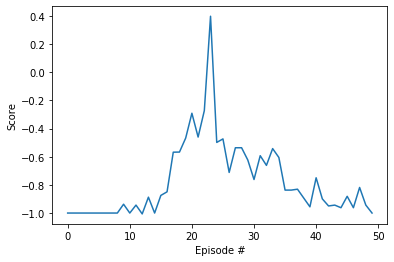

In [60]:
# Neural network input size when not using HER is 
# 36 raycasts parameters X 3 stacks = 108 
params[brainName]['state_size']=  108


scores, replayStats = dqn(n_episodes=50, max_t=500, eps_decay=0.85)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


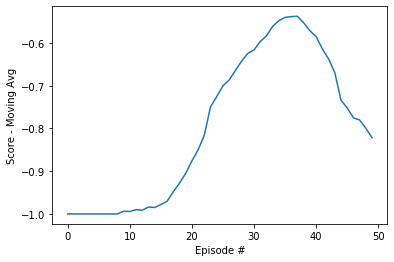

In [72]:
# Moving average of scores
plotLearning(scores = scores,
             window=10,
             label='DQN',
             ylabel='Score - Moving Avg',
             xlabel='Episode #')

### Execute DQN with HER and Reward Shaping

Here we train an agent to learn from Hallway environment using DQN along with Hindsight Experience Replay with reward shaping.

Episode:  1
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
     Step:  300  Scores:  -0.6020000285934657
     Step:  400  Scores:  -0.802000038092956
HER Sample Size: 4  Episode Exp: 499
     Learnt : 64  + 4  - 60
Episode:  1  Average Score:  -1.0000000474974513
Episode:  2
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
     Step:  300  Scores:  -0.6081875283416593
     Step:  400  Scores:  -0.8081875378411496
HER Sample Size: 4  Episode Exp: 499
     Learnt : 64  + 0  - 64
Episode:  2  Average Score:  -1.0030937973715481
Episode:  3
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
     Step:  300  Scores:  -0.6020000285934657
     Step:  400  Scores:  -0.802000038092956
HER Sample Size: 4  Episode Exp: 499
     

     Step:  300  Scores:  -0.614375028089853
     Step:  400  Scores:  -0.8143750375893433
HER Sample Size: 4  Episode Exp: 499
     Learnt : 64  + 16  - 48
Episode:  46  Average Score:  -0.8920992247531894
Episode:  47
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.21433334265020676
     Step:  200  Scores:  -0.414333352149697
     Step:  300  Scores:  -0.5517708571132971
     Step:  400  Scores:  -0.6892083620768972
HER Sample Size: 4  Episode Exp: 499
     Learnt : 64  + 8  - 56
Episode:  47  Average Score:  -0.8910576639696336
Episode:  48
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
     Step:  300  Scores:  -0.5456250265997369
     Step:  400  Scores:  -0.7518333690677537
HER Sample Size: 4  Episode Exp: 499
     Learnt : 64  + 12  - 52
Episode:  48  Average Score:  -0.8909774705216478
Episode:  49
     Step:  0  Scores:  -0.0020000000949949026
     Step:  1

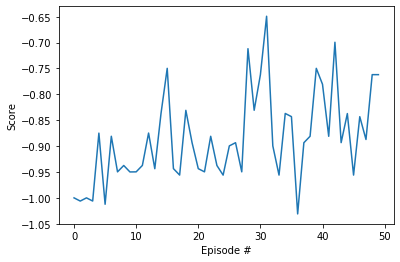

In [32]:
# Neural network input size when using HER is 
# (36 raycasts parameters + 3 positional parameters of goal) X 3 = 117 
params[brainName]['state_size']=  117

scores_HER, replayStats_HER = dqn(useHER=True,
                                  HERSampleSize=4, 
                                  n_episodes=50,
                                  max_t=500,
                                  eps_decay=0.85,
                                  d_threshold=20)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_HER)), scores_HER)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

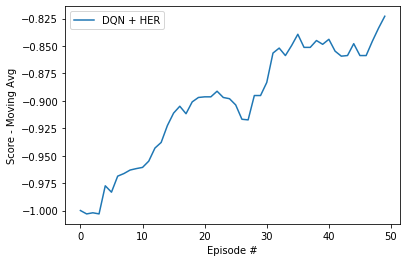

In [39]:
plotLearning(scores = scores_HER,
             window=10,
             label='DQN + HER',
             ylabel='Score - Moving Avg',
             xlabel='Episode #')

The performance is not as good as pure DQN. We can investigate if there are any improvements in performance by reducing the total time steps to 300.

Episode:  1
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
HER Sample Size: 4  Episode Exp: 299
     Learnt : 64  + 0  - 64
Episode:  1  Average Score:  -0.6000000284984708
Episode:  2
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
HER Sample Size: 4  Episode Exp: 299
     Learnt : 64  + 8  - 56
Episode:  2  Average Score:  -0.6000000284984708
Episode:  3
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
HER Sample Size: 4  Episode Exp: 299
     Learnt : 64  + 8  - 56
Episode:  3  Average Score:  -0.6000000284984708
Episode:  4
     Step:  0  Scores:  -0.0020000000949949026
     Step:  100  Scores:  -0.20200000959448516
     Step:  200  Scores:  -0.4020000190939754
HER Sample Size: 4  Episode Exp: 299
     Learnt :

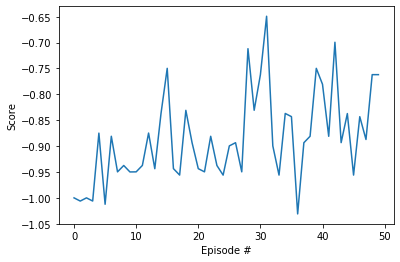

In [46]:
# Neural network input size when using HER is 
# (36 raycasts parameters + 3 positional parameters of goal) X 3 = 117 
params[brainName]['state_size']=  117

scores_HER_2, replayStats_HER_2 = dqn(useHER=True,
                                  HERSampleSize=4, 
                                  n_episodes=50,
                                  max_t=300,
                                  eps_decay=0.85,
                                  d_threshold=20)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_HER)), scores_HER)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

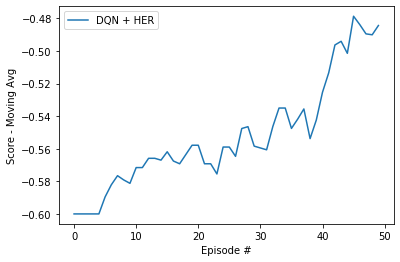

In [47]:
plotLearning(scores = scores_HER_2,
             window=10,
             label='DQN + HER',
             ylabel='Score - Moving Avg',
             xlabel='Episode #')

## Evaluation

### Comparisson between DQN and DQN + HER scores

The trajectory is steadily rising, but the overall performance is better in pure DQN. An argument could be made from these results that since HER rewards alternate trajectories, an episode having 500 steps could cause the agent to learn longer trajectories to reach the goal, which are unnecessary. But DQN with HER tested lower time steps (300) and by varying the epsilon value for farther exploration also didn’t yield any better performance. 
 

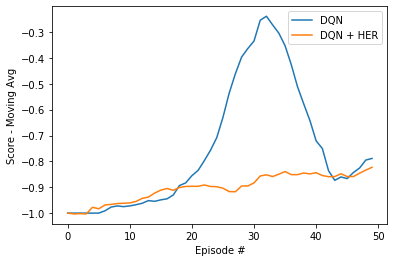

In [41]:
plotLearning(scores = scores,
             window=10,
             label='DQN',
             ylabel='Score - Moving Avg',
             xlabel='Episode #')
plotLearning(scores = scores_HER,
             window=10,
             label='DQN + HER',
             ylabel='Score - Moving Avg',
             xlabel='Episode #')

### Total number of experiences in memory buffer

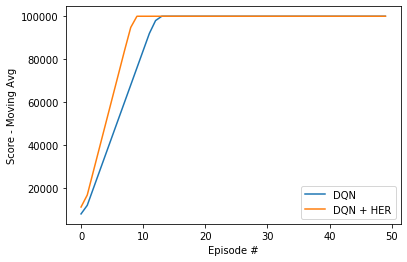

In [65]:
p = 0
plotLearning(scores = [item[p] for item in  replayStats], 
             window=1, 
             label='DQN', 
             ylabel='Score - Moving Avg', 
             xlabel='Episode #')
plotLearning(scores = [item[p] for item in  replayStats_HER], 
             window=1, label='DQN + HER', 
             ylabel='Score - Moving Avg', 
             xlabel='Episode #')

### Number of positive experiences in memory buffer

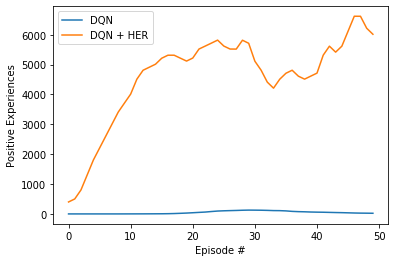

In [78]:
p = 1
plotLearning(scores = [item[p] for item in  replayStats], 
             window=1, 
             label='DQN', 
             ylabel='Score - Moving Avg', 
             xlabel='Episode #')
plotLearning(scores = [item[p] for item in  replayStats_HER], 
             window=1, label='DQN + HER', 
             ylabel='Score - Moving Avg', 
             xlabel='Episode #')

### Number of negative experiences in memory buffer

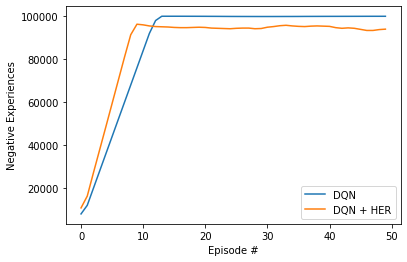

In [79]:
p = 2
plotLearning(scores = [item[p] for item in  replayStats], 
             window=1, 
             label='DQN', 
             ylabel='Score - Moving Avg', 
             xlabel='Episode #')
plotLearning(scores = [item[p] for item in  replayStats_HER], 
             window=1, label='DQN + HER', 
             ylabel='Score - Moving Avg', 
             xlabel='Episode #')

### Number of neutral experiences in memory buffer

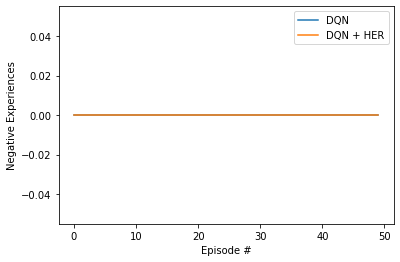

In [77]:
p = 3
plotLearning(scores = [item[p] for item in  replayStats], 
             window=1, 
             label='DQN', 
             ylabel='Score - Moving Avg', 
             xlabel='Episode #')
plotLearning(scores = [item[p] for item in  replayStats_HER], 
             window=1, label='DQN + HER', 
             ylabel='Score - Moving Avg', 
             xlabel='Episode #')

In [ ]:
# Disconnect the environment
env.close()

### References

This DQN implementation alone was taken from [Udacity's course on deep Q-networks](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn). The hidden network size and batch size was increased as it showed better performance on DQN. Other parameters were unchanged. The original implementation was intended for OpenAI Lunar Lander (https://gym.openai.com/envs/LunarLander-v2/)